In [24]:
import pandas as pd
import numpy as np
import keras
import tensorflow
import matplotlib.pyplot as plt

In [20]:
df = pd.read_excel(r'C:\Users\tom.rigter\PPAnalytics\EPEXSPOT.xlsx')
df.head()

,Date,Time,EPEX_SPOT_NL
0,2015-01-01,00:00:00,38.50
1,2015-01-01,01:00:00,38.22
2,2015-01-01,02:00:00,35.60
3,2015-01-01,03:00:00,33.00
4,2015-01-01,04:00:00,27.41


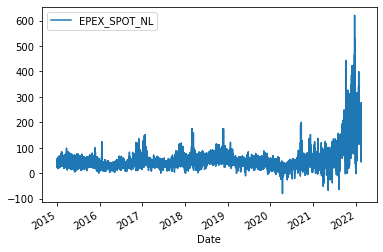

In [25]:
df.plot(x='Date', y='EPEX_SPOT_NL')
plt.show()